# Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection 
This is the code for the paper entitled "[**Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection**](https://arxiv.org/pdf/2409.03141)" accepted in Workshop on Autonomous Cybersecurity (AutonomousCyber 2024), ACM CCS 2024 (Top Cybersecurity Conference).  
Authors: Li Yang (liyanghart@gmail.com) and Abdallah Shami  

If you find this repository useful in your research, please cite:  
L. Yang and A. Shami, “Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection,” in Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber ’24), 2024 ACM SIGSAC Conference on Computer and Communications Security (CCS’24), 2024, pp. 1–11. doi: 10.1145/3689933.3690833.

```
@INPROCEEDINGS{3690833,
  author={Yang, Li and Shami, Abdallah},
  title = {Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection},
  booktitle = {Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber '24), ACM Conference on Computer and Communications Security (CCS) 2024},
  year = {2024},
  address = {Salt Lake City, UT, USA},
  pages = {1-11},
  doi = {10.1145/3689933.3690833}
}
```

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb
import catboost as cb
import time

## Dataset 1: CICIDS2017
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  

Due to the large size of this dataset and the file size limit of GitHub, the sampled subset of CICIDS2017 is used. The subsets are in the "Data" folder.  PS: The results might be different from the paper due to the size difference of the dataset.

The Canadian Institute for Cybersecurity Intrusion Detection System 2017 (CICIDS2017) dataset has the most updated network threats. The CICIDS2017 dataset is close to real-world network data since it has a large amount of network traffic data, a variety of network features, various types of attacks, and highly imbalanced classes.


### Load data

In [3]:
# Read the dataset
df = pd.read_csv('../../dataset/OutputMay2025/wedfri_2_train_flinked.csv', parse_dates=['Timestamp'])

In [4]:
df_test = pd.read_csv('../../dataset/OutputMay2025/wedfri_2_test_flinked.csv', parse_dates=['Timestamp'])

In [5]:
df_test['Label'].value_counts()

Label
Benign          99786
Portscan        31787
Slowhttptest      894
Name: count, dtype: int64

In [6]:
df_benign = df[df['Label'] == 'Benign'].sort_values(by='Timestamp')
df_ps = df[df['Label'] == 'Portscan'].sort_values(by='Timestamp')
df_dos = df[df['Label'] == 'Slowhttptest'].sort_values(by='Timestamp')

In [7]:
df_benign_val = df_benign.iloc[-120990:]
df_benign_train = df_benign[~df_benign.index.isin(df_benign_val.index)]
df_ps_val = df_ps.iloc[-31786:]
df_ps_train = df_ps[~df_ps.index.isin(df_ps_val.index)]
df_dos_val = df_dos.iloc[-1139:]
df_dos_train = df_dos[~df_dos.index.isin(df_dos_val.index)]

In [31]:
# df['Label'] = df['Label'].map({
#     "Benign": "Benign",
#     "Slowloris": "Slowloris"
# })
# df = df.dropna(subset=['Label'])
# df['Label'].value_counts(dropna=False)

In [30]:
# df_test[df_test['Label'] == 'Slowloris'].sort_values(by='Timestamp').reset_index().iloc[700]['Timestamp']

In [29]:
# df_test['Label'] = df_test['Label'].map({
#     "Benign": "Benign",
#     "Slowloris": "Slowloris"
# })
# df_test = df_test.dropna(subset=['Label'])
# df_test['Label'].value_counts(dropna=False)

In [24]:
# df_test[df_test['Label'] == 'Slowloris'].sort_values(by='Timestamp').iloc[:int(len(df_test[df_test['Label'] == 'Slowloris'])*(1/2))]

In [25]:
# randomizing = df_test[df_test['Timestamp'] <= pd.Timestamp('2017-07-05 13:08:15.865809')]
# df_test = df_test[~df_test.index.isin(randomizing.index)]

In [26]:
# df = pd.concat([df, randomizing])

In [27]:
# # print the class distribution of the last column
# df['Label'].value_counts()

In [28]:
# df_test['Label'].value_counts()

In [ ]:
# df_train = pd.concat([df_benign_train, df_ps_train, df_dos_train])
# df_val = pd.concat([df_benign_val, df_ps_val, df_dos_val])

In [ ]:
# df_train['Label'].value_counts()

Label
Benign       363427
Portscan      95468
Slowloris      3424
Name: count, dtype: int64

In [ ]:
# df_val['Label'].value_counts()

Label
Benign       120990
Portscan      31786
Slowloris      1139
Name: count, dtype: int64

In [ ]:
# df_train = df_train.drop(['index', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'], axis=1)
# df_val = df_val.drop(['index', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'], axis=1)
# df_test = df_test.drop(['index', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'], axis=1)

In [9]:
df = df.drop(['index', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'], axis=1)
df_test = df_test.drop(['index', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'], axis=1)

In [10]:
X_test = df_test.drop('Label', axis=1)

In [11]:
y_test = df_test['Label']

### Data pre-processing

In [12]:
# Encode the dataset
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Label'])

In [13]:
df['Label'].value_counts()

Label
0    505631
1    127253
2      3933
Name: count, dtype: int64

In [14]:
y_test = labelencoder.transform(y_test)
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
df.isnull().any().any()

False

In [16]:
df.isna().any().any()

False

In [25]:
# address empty values
# if df.isnull().values.any() or np.isinf(df).values.any(): # if there is any empty or infinite values
#     print("THERE ARE")
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     df.fillna(0, inplace = True) 

In [43]:
# # Debug
# X_train = df.drop(['Label'],axis=1).values 
# y_train = df['Label'].values.reshape(-1,1)
# X_val = X_test
# y_val = y_test

In [68]:
# Split the dataset into training and testing
X = df.drop(['Label'],axis=1) 
y = df['Label'].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_val, y_train, y_val = train_test_split(X,y, train_size = 0.75, test_size = 0.25, random_state = 0, stratify = y)
# 0.75 & 0.25 means 60% train and 20% validation FROM WHOLE DATASET (counting test)

In [ ]:
# X_train = df_train.drop(["Label"], axis=1)
# y_train = labelencoder.transform(df_train["Label"])
# X_val = df_val.drop(["Label"], axis=1)
# y_val = labelencoder.transform(df_val["Label"])

In [18]:
labelencoder.classes_

array(['Benign', 'Portscan', 'Slowhttptest'], dtype=object)

## Machine learning model training

### Training six base learners (for comparison purposes): 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

#### DT

In [26]:
pd.set_option('display.max_columns', None)

In [23]:
len(X_train)

393700

In [24]:
len(y_train)

393700

Training time:  15.588545083999634
Prediction time per sample:  0.00012565103144334351
Cross-Validation scores:  [0.999799   0.99975503 0.99959172]
Mean of Cross-Validation scores:  0.9997152500355937
Accuracy of DT: 0.99974875160956
Precision of DT: 0.9997482102666544
Recall of DT: 0.99974875160956
F1-score of DT: 0.999748441347683
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.98      0.98      0.98       983

    accuracy                           1.00    159205
   macro avg       0.99      0.99      0.99    159205
weighted avg       1.00      1.00      1.00    159205



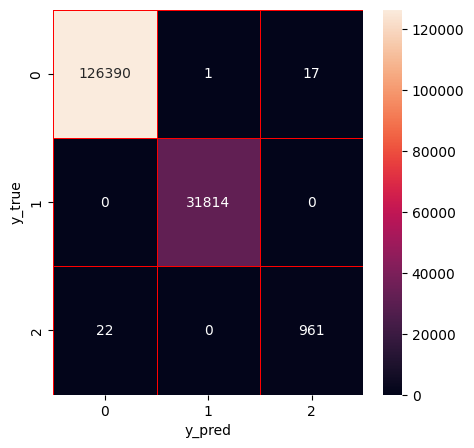

In [19]:
# %%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt


# Decision tree training and prediction with 3-fold cross-validation
dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_score(dt, X_train, y_train, cv=3, n_jobs=4)

# calculate the training time
start = time.time()
dt.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val)*1000)

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0002806012830082209
Accuracy of DT: 0.9991092121056565
Precision of DT: 0.9991063934111597
Recall of DT: 0.9991092121056565
F1-score of DT: 0.9991070910223836
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99786
           1       1.00      1.00      1.00     31787
           2       0.97      0.95      0.96       894

    accuracy                           1.00    132467
   macro avg       0.99      0.98      0.99    132467
weighted avg       1.00      1.00      1.00    132467



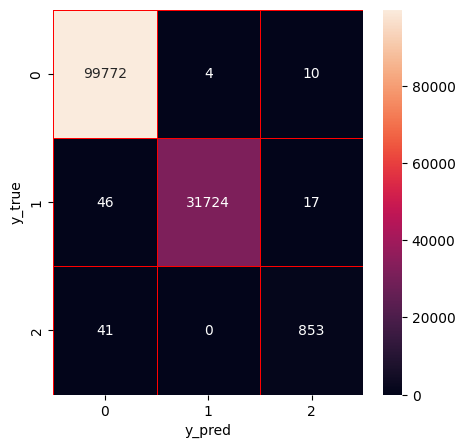

In [22]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test)*1000)

y_true = y_test

# Print out the cross-validation scores and mean of them
# print('Cross-Validation scores: ', dt_scores)
# print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### RF

Training time:  22.51149034500122
Prediction time:  0.0013442881266595521 ms
Cross-Validation scores:  [0.99984925 0.99984297 0.99966709]
Mean of Cross-Validation scores:  0.9997864375266953
Accuracy of RF: 0.999868094595019
Precision of RF: 0.9998704757462856
Recall of RF: 0.999868094595019
F1-score of RF: 0.9998687209233856
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.98      1.00      0.99       983

    accuracy                           1.00    159205
   macro avg       0.99      1.00      1.00    159205
weighted avg       1.00      1.00      1.00    159205



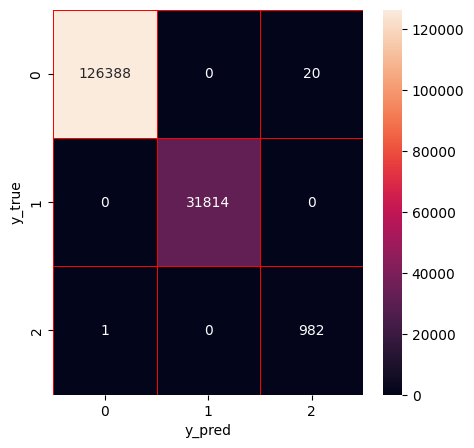

In [23]:
# %%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0, n_jobs=8)
rf_scores = cross_val_score(rf, X_train, y_train, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
rf.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

# Evaluation metrics
rf_score = rf.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Prediction time:  0.001017154453232117 ms
Accuracy of RF: 0.9993130364543622
Precision of RF: 0.9993130945211964
Recall of RF: 0.9993130364543622
F1-score of RF: 0.9993128160267756
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99786
           1       1.00      1.00      1.00     31787
           2       0.99      0.99      0.99       894

    accuracy                           1.00    132467
   macro avg       1.00      0.99      1.00    132467
weighted avg       1.00      1.00      1.00    132467



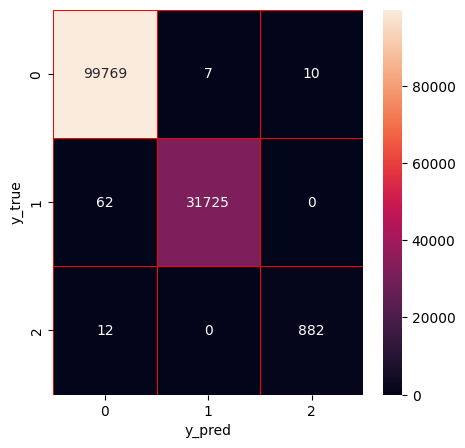

In [24]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
rf_score = rf.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### ET

Training time:  15.827863216400146
Prediction time:  0.001293729101195227 ms
Cross-Validation scores:  [0.99981156 0.99979272 0.99964825]
Mean of Cross-Validation scores:  0.9997508437811445
Accuracy of ET: 0.999830407336453
Precision of ET: 0.9998331429692934
Recall of ET: 0.999830407336453
F1-score of ET: 0.9998312126157812
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.98      1.00      0.99       983

    accuracy                           1.00    159205
   macro avg       0.99      1.00      1.00    159205
weighted avg       1.00      1.00      1.00    159205



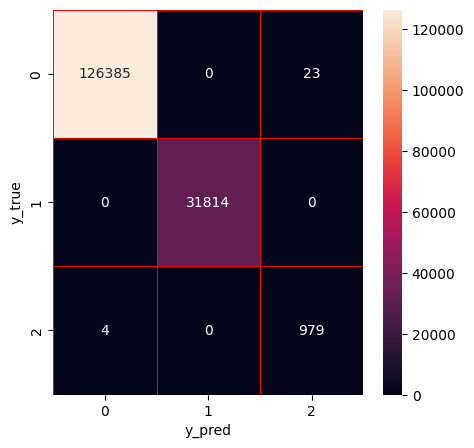

In [25]:
# %%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=8)
et_scores = cross_val_score(et, X_train, y_train, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
et.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(X_val) * 1000, 'ms')


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

# Evaluation metrics
et_score = et.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### XGBoost

Training time:  7.148115873336792
Prediction time per sample:  0.0004102392961307932
Cross-Validation scores:  [0.999799   0.99978644 0.99966081]
Mean of Cross-Validation scores:  0.9997487500314062
Accuracy of XGBoost: 0.999799001287648
Precision of XGBoost: 0.9998010236614678
Recall of XGBoost: 0.999799001287648
F1-score of XGBoost: 0.9997997063235714
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.98      0.99      0.98       983

    accuracy                           1.00    159205
   macro avg       0.99      1.00      0.99    159205
weighted avg       1.00      1.00      1.00    159205



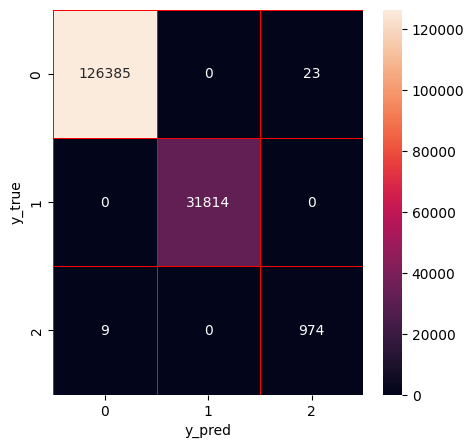

In [26]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=8)
xg_scores = cross_val_score(xg, X_train, y_train, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
xg.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

# Evaluation metrics
xg_score = xg.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16654
[LightGBM] [Info] Number of data points in the train set: 318408, number of used features: 81
[LightGBM] [Info] Start training from score -0.230672
[LightGBM] [Info] Start training from score -1.610311
[LightGBM] [Info] Start training from score -5.087333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16621
[LightGBM] [Info] Number of data points in the train set: 318408, number of used features: 81
[LightGBM] [Info] Start training from score -0.230676
[LightGBM] [Info] Start training from score -1.610311
[LightGBM] [Info] St

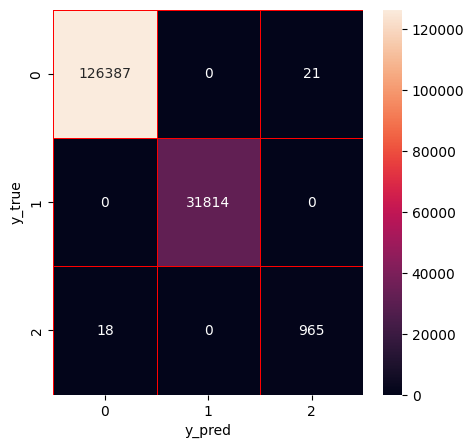

In [27]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=8)
lgbm_scores = cross_val_score(lgbm, X_train, y_train, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
lgbm.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)



y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Prediction time per sample:  0.0012294970407733404
Cross-Validation scores:  [0.99984925 0.99978016 0.99966709]
Mean of Cross-Validation scores:  0.9997655000293125
Accuracy of LightGBM: 0.999162055455321
Precision of LightGBM: 0.9991622188397085
Recall of LightGBM: 0.999162055455321
F1-score of LightGBM: 0.9991619919585374
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99786
           1       1.00      1.00      1.00     31787
           2       0.98      0.98      0.98       894

    accuracy                           1.00    132467
   macro avg       0.99      0.99      0.99    132467
weighted avg       1.00      1.00      1.00    132467



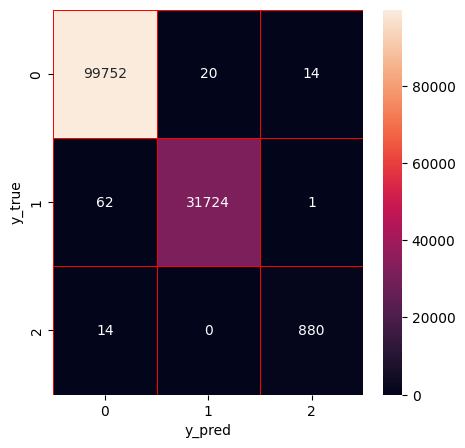

In [28]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)



y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Catboost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, verbose=False, thread_count=8)
cat_scores = cross_val_score(cat, X_train, y_train, cv=3, n_jobs=8)


# calculate the training time
start = time.time()
cat.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)


Training time:  65.31108069419861
Prediction time per sample:  0.009554534142484828
Cross-Validation scores:  [0.99983669 0.999799   0.99969222]
Mean of Cross-Validation scores:  0.999775968778004


ValueError: Found input variables with inconsistent numbers of samples: [132467, 159205]

Prediction time per sample:  0.00041214718388416394
Cross-Validation scores:  [0.99983669 0.999799   0.99969222]
Mean of Cross-Validation scores:  0.999775968778004
Accuracy of CatBoost: 0.999805282497409
Precision of CatBoost: 0.9998082544512985
Recall of CatBoost: 0.999805282497409
F1-score of CatBoost: 0.9998062070773784
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.98      0.99      0.98       983

    accuracy                           1.00    159205
   macro avg       0.99      1.00      0.99    159205
weighted avg       1.00      1.00      1.00    159205



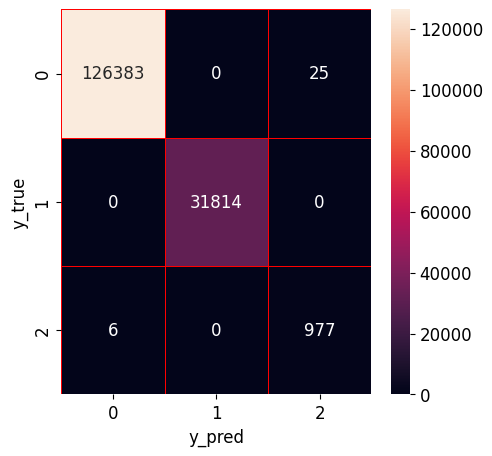

In [76]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

# Evaluation metrics
cat_score = cat.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [77]:
# record the results
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_val)
dt_prob_train=dt.predict_proba(X_train)
dt_prob_test=dt.predict_proba(X_val)

rf_train=rf.predict(X_train)
rf_test=rf.predict(X_val)
rf_prob_train=rf.predict_proba(X_train)
rf_prob_test=rf.predict_proba(X_val)

et_train=et.predict(X_train)
et_test=et.predict(X_val)
et_prob_train=et.predict_proba(X_train)
et_prob_test=et.predict_proba(X_val)

xg_train=xg.predict(X_train)
xg_test=xg.predict(X_val)
xg_prob_train=xg.predict_proba(X_train)
xg_prob_test=xg.predict_proba(X_val)

lgbm_train=lgbm.predict(X_train)
lgbm_test=lgbm.predict(X_val)
lgbm_prob_train=lgbm.predict_proba(X_train)
lgbm_prob_test=lgbm.predict_proba(X_val)

cat_train=cat.predict(X_train)
cat_test=cat.predict(X_val)
cat_prob_train=cat.predict_proba(X_train)
cat_prob_test=cat.predict_proba(X_val)


In [35]:
import joblib

joblib.dump(dt, "./wedfri_2_models/prefs/dt.pkl")
joblib.dump(rf, "./wedfri_2_models/prefs/rf.pkl")
joblib.dump(et, "./wedfri_2_models/prefs/et.pkl")
joblib.dump(xg, "./wedfri_2_models/prefs/xg.pkl")
joblib.dump(lgbm, "./wedfri_2_models/prefs/lgbm.pkl")
joblib.dump(cat, "./wedfri_2_models/prefs/cat.pkl")

['./wedfri_2_models/prefs/cat.pkl']

In [36]:
import gc
gc.collect()

11638

## Model selection

In [78]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]

In [79]:
top_3_models

['rf', 'cat', 'lgbm']

## Model Ensemble

In [80]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
lgbm_train=lgbm_train.reshape(-1, 1)
cat_train=cat_train.reshape(-1, 1)


dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)
lgbm_test=lgbm_test.reshape(-1, 1)
cat_test=cat_test.reshape(-1, 1)

Training time of Stacking: 1.1131892204284668
Testing time of Stacking: 6.348743596263711e-05
Accuracy of Stacking: 0.999868094595019
Precision of Stacking: 0.9998704757462856
Recall of Stacking: 0.999868094595019
F1-score of Stacking: 0.9998687209233856
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.98      1.00      0.99       983

    accuracy                           1.00    159205
   macro avg       0.99      1.00      1.00    159205
weighted avg       1.00      1.00      1.00    159205



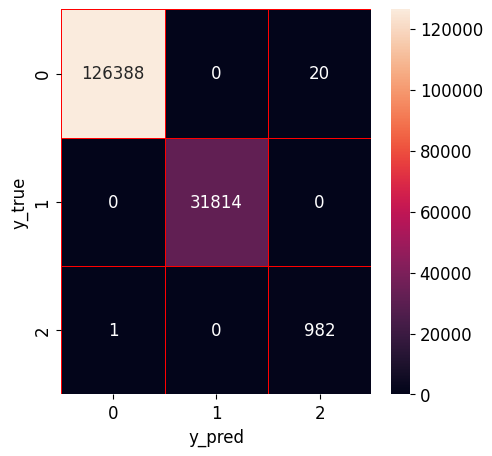

In [81]:
# Ensemble method 1: traditional stacking

# Get the predictions of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

# Stack the predictions of the top-3 models
x_train = np.concatenate(top_3_train_predictions, axis=1)
x_val = np.concatenate(top_3_test_predictions, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0, n_jobs=8).fit(x_train, y_train)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Training time of Stacking: 1.9468786716461182
Testing time of Stacking: 6.754881083480468e-05
Accuracy of Stacking: 0.999842969755975
Precision of Stacking: 0.9998442171161671
Recall of Stacking: 0.999842969755975
F1-score of Stacking: 0.9998434031966679
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.98      0.99      0.99       983

    accuracy                           1.00    159205
   macro avg       0.99      1.00      1.00    159205
weighted avg       1.00      1.00      1.00    159205



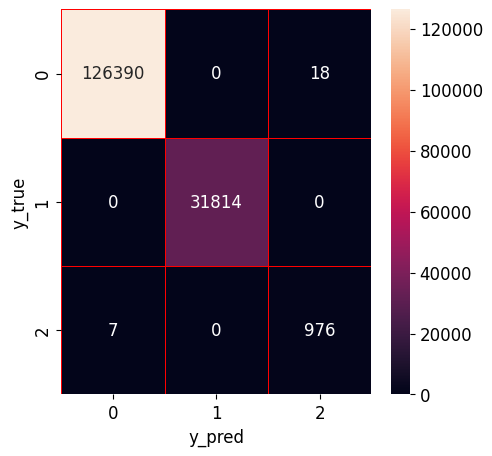

In [82]:
# Ensemble method 2: confidence-based stacking

# Get the prediction probabilities of the top-3 models
top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Stack the predictions and prediction probabilities of the top-3 models
x_train = np.concatenate(top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_test_proba, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0).fit(x_train, y_train)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Training time of Stacking: 1.8106706142425537
Testing time of Stacking: 8.061799170110496e-05
Accuracy of Stacking: 0.999868094595019
Precision of Stacking: 0.9998704757462856
Recall of Stacking: 0.999868094595019
F1-score of Stacking: 0.9998687209233856
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.98      1.00      0.99       983

    accuracy                           1.00    159205
   macro avg       0.99      1.00      1.00    159205
weighted avg       1.00      1.00      1.00    159205



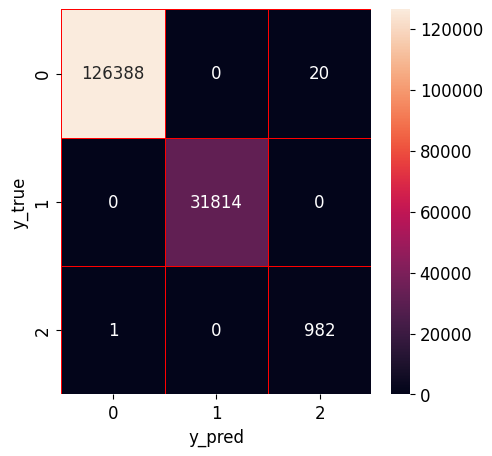

In [83]:
# Ensemble method 3: hybrid stacking

# Get the predictions and prediction probabilities of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_train = np.concatenate(top_3_train_predictions + top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_test_predictions + top_3_test_proba, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0).fit(x_train, y_train)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Automated Feature Selection

In [84]:
# Save the feature importance lists generated by base ML algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xg_feature = xg.feature_importances_
lgbm_feature = lgbm.feature_importances_
cat_feature = cat.feature_importances_

In [85]:
lgbm_feature = lgbm_feature/sum(lgbm_feature)
cat_feature = cat_feature/sum(cat_feature)

In [86]:
# Get the feature importances of the top-3 models
top_3_importances = [globals()[model.lower() + '_feature'] for model in top_3_models]

# Calculate the average importance of each feature
avg_feature = np.mean(top_3_importances, axis=0)

feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)


Features sorted by their score:
[(0.1129, 'Flow Duration'), (0.0466, 'Flow IAT Max'), (0.042, 'SYN Flag Count'), (0.0399, 'Flow IAT Min'), (0.0374, 'Fwd IAT Min'), (0.0353, 'Total Length of Fwd Packet'), (0.0338, 'Fwd Packet Length Max'), (0.0313, 'Bwd RST Flags'), (0.0305, 'Packet Length Mean'), (0.0299, 'FWD Init Win Bytes'), (0.0263, 'Average Packet Size'), (0.0242, 'Bwd Packets/s'), (0.024, 'Idle Min'), (0.0227, 'Flow Packets/s'), (0.0219, 'Fwd Packets/s'), (0.0209, 'Fwd Seg Size Min'), (0.018, 'Fwd Act Data Pkts'), (0.0172, 'Idle Std'), (0.017, 'Fwd Header Length'), (0.0161, 'Flow IAT Mean'), (0.016, 'Flow Bytes/s'), (0.015, 'Bwd Packet Length Max'), (0.0147, 'RST Flag Count'), (0.0138, 'Subflow Fwd Packets'), (0.0128, 'Fwd Packet Length Mean'), (0.0127, 'Total Fwd Packet'), (0.0124, 'Flow IAT Std'), (0.0121, 'Active Min'), (0.012, 'Idle Mean'), (0.012, 'Fwd Segment Size Avg'), (0.0119, 'Bwd Segment Size Avg'), (0.0117, 'Packet Length Max'), (0.0116, 'Total Length of Bwd Packet'),

In [87]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break        

In [ ]:
# regenerate the training and test sets with the selected features
# note that it uses random_state, so the results are the same, just the features are now selected

X_fs = X[fs]
X_train, X_val, y_train, y_val = train_test_split(X_fs, y, train_size=0.75, test_size=0.25, random_state=0, stratify=y)

In [99]:
# save the dataset with the selected features
df_fs = pd.DataFrame(X_fs, columns=fs)
df_fs['Label'] = y
df_fs.to_csv('./wedfri_2_models/df_fs.csv', index=False)

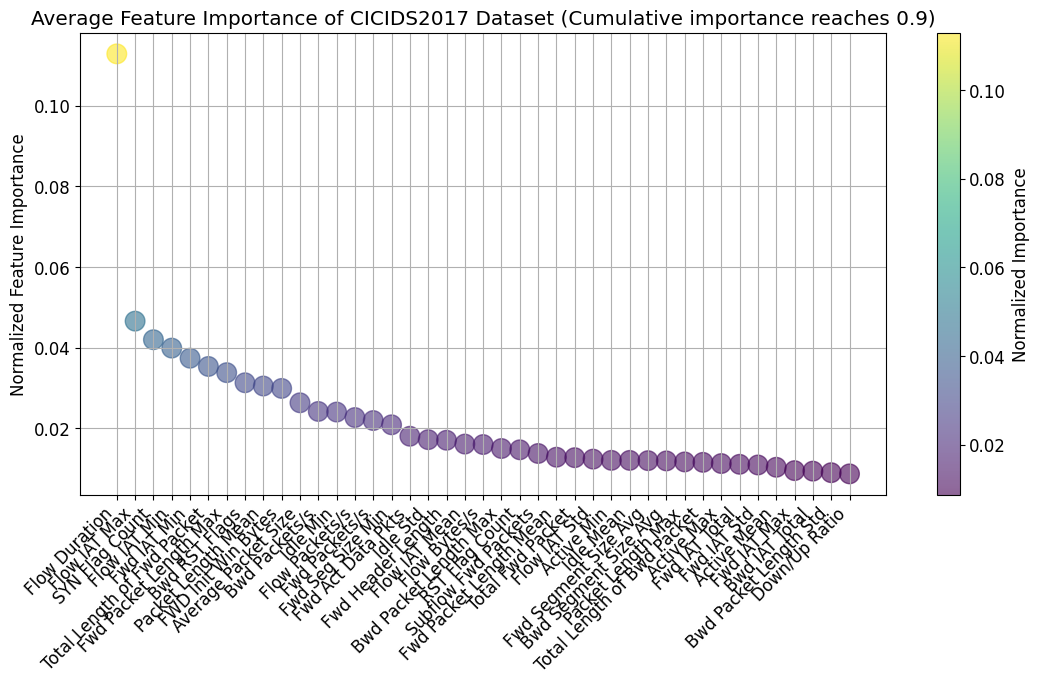

In [100]:
# Plot the feature importance of the top-3 models
plt.rcParams.update({'font.size': 12})

# Create a DataFrame for easier plotting
features = pd.DataFrame({
    'Feature': df.drop(['Label'],axis=1).columns,
    'Importance': avg_feature
})

# Sort features by importance
features = features.sort_values(by='Importance', ascending=False)

# Calculate cumulative importance and filter features
features['Cumulative'] = features['Importance'].cumsum()
filtered_features = features[features['Cumulative'] <= 0.9]

# Plotting
plt.figure(figsize=(13, 6))
scatter = plt.scatter(x='Feature', y='Importance', s=200, c='Importance', cmap='viridis', alpha=0.6, data=filtered_features)
plt.colorbar(scatter, label='Normalized Importance')
plt.xticks(rotation=45, ha='right')
plt.title('Average Feature Importance of CICIDS2017 Dataset (Cumulative importance reaches 0.9)')
plt.ylabel('Normalized Feature Importance')
plt.grid(True)
plt.show()

In [103]:
print(fs)

['Flow Duration', 'Flow IAT Max', 'SYN Flag Count', 'Flow IAT Min', 'Fwd IAT Min', 'Total Length of Fwd Packet', 'Fwd Packet Length Max', 'Bwd RST Flags', 'Packet Length Mean', 'FWD Init Win Bytes', 'Average Packet Size', 'Bwd Packets/s', 'Idle Min', 'Flow Packets/s', 'Fwd Packets/s', 'Fwd Seg Size Min', 'Fwd Act Data Pkts', 'Idle Std', 'Fwd Header Length', 'Flow IAT Mean', 'Flow Bytes/s', 'Bwd Packet Length Max', 'RST Flag Count', 'Subflow Fwd Packets', 'Fwd Packet Length Mean', 'Total Fwd Packet', 'Flow IAT Std', 'Active Min', 'Idle Mean', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Packet Length Max', 'Total Length of Bwd Packet', 'Active Max', 'Fwd IAT Total', 'Fwd IAT Std', 'Active Mean', 'Fwd IAT Max', 'Bwd IAT Total', 'Bwd Packet Length Std', 'Down/Up Ratio', 'Idle Max']


### Data Balancing by Proposed TVAE-based Method

In [104]:
pd.Series(y_train).value_counts()

0    379223
1     95439
2      2950
Name: count, dtype: int64

In [141]:
df_fs

,Flow Duration,Flow IAT Max,SYN Flag Count,Flow IAT Min,Fwd IAT Min,Total Length of Fwd Packet,Fwd Packet Length Max,Bwd RST Flags,Packet Length Mean,FWD Init Win Bytes,...,Active Max,Fwd IAT Total,Fwd IAT Std,Active Mean,Fwd IAT Max,Bwd IAT Total,Bwd Packet Length Std,Down/Up Ratio,Idle Max,Label
0,527.0,73.0,4,0.0,1.0,172.0,79.0,1,23.263158,29200,...,0.0,480.0,39.558242,0.0,109.0,450.0,65.873255,0.583333,0.0,0
1,1194.0,810.0,4,1.0,1.0,3150.0,1575.0,1,315.000000,29200,...,0.0,1096.0,284.233550,0.0,915.0,1156.0,694.509719,0.818182,0.0,0
2,15185.0,13391.0,4,0.0,2.0,3452.0,1313.0,1,352.678571,29200,...,0.0,15156.0,3430.037293,0.0,13391.0,15112.0,937.110271,0.750000,0.0,0
3,1186.0,794.0,4,0.0,1.0,3150.0,1575.0,1,331.684211,29200,...,0.0,1093.0,297.034557,0.0,910.0,1139.0,694.950678,0.900000,0.0,0
4,483.0,74.0,4,0.0,0.0,172.0,79.0,1,23.263158,29200,...,0.0,434.0,41.654204,0.0,109.0,420.0,65.873255,0.583333,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636812,33.0,33.0,1,33.0,0.0,0.0,0.0,1,0.000000,29200,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,1
636813,60.0,60.0,1,60.0,0.0,0.0,0.0,1,0.000000,29200,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,1
636814,44.0,44.0,1,44.0,0.0,0.0,0.0,1,0.000000,29200,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,1
636815,49.0,49.0,1,49.0,0.0,0.0,0.0,1,0.000000,29200,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,1


In [145]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
# metadata.detect_from_csv(filepath='./wedfri_2_models/df_fs.csv')
metadata.detect_from_dataframe(df_fs)

In [ ]:
# training_set, test_set = train_test_split(df, train_size=0.75, test_size=0.25, random_state=0, stratify=df['Label'])
# X_train = training_set[fs]
# y_train = training_set.iloc[:, -1]
# X_val = test_set[fs]
# y_val = test_set.iloc[:, -1]

In [ ]:
# training_set['Label'].value_counts()

Label
0    294673
1    120891
Name: count, dtype: int64

In [111]:
y_train = pd.Series(y_train)
y_val = pd.Series(y_val)

In [146]:
from sdv.single_table import TVAESynthesizer
# Identify the average number of samples per class
average_samples = y_train.value_counts().mean()

# Identify minority classes with less than half the average number of samples
minority_classes = y_train.value_counts()
minority_classes = minority_classes[minority_classes < average_samples / 2].index.tolist()

# Prepare an empty DataFrame to collect synthetic data
synthetic_data = pd.DataFrame()

In [128]:
y_train.index = X_train.index

In [147]:
# Generating synthetic samples for each minority class using TVAE
for cls in minority_classes:
    cls_samples = X_train[y_train == cls]
    num_samples_needed = int(average_samples - len(cls_samples))
    
    # Initialize the TVAE model with detected metadata
    tvaegan = TVAESynthesizer(metadata=metadata, cuda=True, verbose=True)
    
    # Fit the TVAE model on the minority class samples
    tvaegan.fit(cls_samples.assign(Label=y_train[y_train == cls]))  # add Label temporarily for TVAE training
    
    # Generate synthetic instances to match the average class sample size
    new_samples = tvaegan.sample(num_samples_needed)
    
    # Append the new synthetic instances to the synthetic data list
    synthetic_data = pd.concat([synthetic_data, new_samples], ignore_index=True)

Loss: -232.744: 100%|██████████| 300/300 [00:32<00:00,  9.22it/s]


In [148]:
# Concatenate the original and synthetic data to form a balanced dataset
balanced_data = pd.concat([X_train.assign(Label=y_train), synthetic_data], ignore_index=True)

# Display the new distribution of labels in the balanced dataset
print(balanced_data['Label'].value_counts())

# Prepare the balanced dataset for model training
X_train_balanced = balanced_data.drop(['Label'], axis=1)
y_train_balanced = balanced_data['Label']

Label
0    379223
2    159204
1     95439
Name: count, dtype: int64


In [151]:
X_val.reset_index(drop=True).to_csv("./wedfri_2_models/fs_X_val.csv", index=False)

In [152]:
X_train_balanced.to_csv("./wedfri_2_models/fs_X_train_balanced.csv", index=False)

In [153]:
y_val.reset_index(drop=True).to_csv("./wedfri_2_models/fs_y_val.csv", index=False)

In [ ]:
y_train_balanced.to_csv("./wedfri_2_models/fs_y_val.csv", index=False)

# Testing

In [155]:
# X_train_balanced = df_fs.drop(['Label'], axis=1)
# y_train_balanced = df_fs['Label']

## Machine learning model training

### Training six base learners: 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

In [172]:
POST_FS_MODEL_OUTPUT = "./wedfri_2_models/postfs"

### DT

Training time:  20.898376941680908
Prediction time per sample:  0.00022249954706205614
Cross-Validation scores:  [0.99273034 0.99979175 0.99968763]
Mean of Cross-Validation scores:  0.9974032402501316
Accuracy of DT: 0.999736189190038
Precision of DT: 0.9997379877120328
Recall of DT: 0.999736189190038
F1-score of DT: 0.9997368994236868
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.97      0.98      0.98       983

    accuracy                           1.00    159205
   macro avg       0.99      0.99      0.99    159205
weighted avg       1.00      1.00      1.00    159205



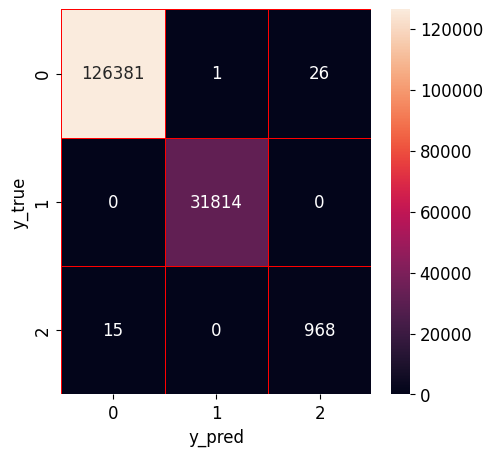

In [157]:
# %%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt


# Decision tree training and prediction with 3-fold cross-validation
dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_score(dt, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
dt.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val)*1000)

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [160]:
X_test_fs = X_test[fs]

In [ ]:
# X_test = df_test[fs]
# y_test = labelencoder.transform(df_test['Label'])

Prediction time per sample:  0.00025843813004894323
Accuracy of DT: 0.9991847026051771
Precision of DT: 0.9991846029428978
Recall of DT: 0.9991847026051771
F1-score of DT: 0.9991843160230921
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99786
           1       1.00      1.00      1.00     31787
           2       0.98      0.97      0.97       894

    accuracy                           1.00    132467
   macro avg       0.99      0.99      0.99    132467
weighted avg       1.00      1.00      1.00    132467



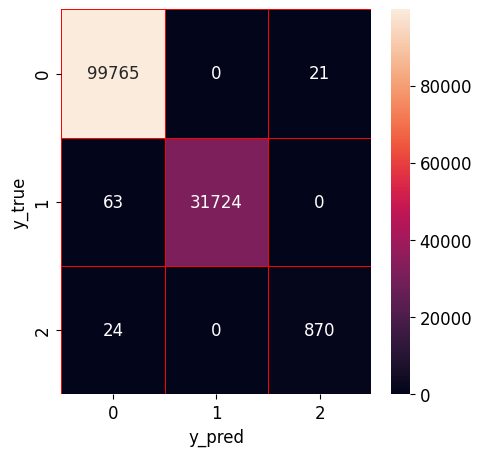

In [167]:
start = time.time()
y_predict = dt.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)

y_true = y_test

# Print out the cross-validation scores and mean of them
# print('Cross-Validation scores: ', dt_scores)
# print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [168]:
joblib.dump(dt, "./wedfri_2_models/postfs/dt_untuned.pkl")

['./wedfri_2_models/postfs/dt_untuned.pkl']

100%|██████████| 20/20 [03:24<00:00, 10.20s/trial, best loss: -0.9996071724864023]
Decision Tree: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 9}
Accuracy of DT: 0.999648252253384
Precision of DT: 0.9996592602799684
Recall of DT: 0.999648252253384
F1-score of DT: 0.9996514644826636
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.95      0.99      0.97       983

    accuracy                           1.00    159205
   macro avg       0.98      1.00      0.99    159205
weighted avg       1.00      1.00      1.00    159205



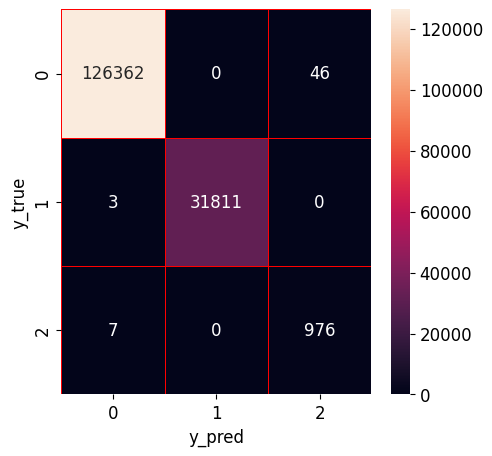

In [169]:
# Hyperparameter Optimization using BO-TPE

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = DecisionTreeClassifier(random_state=0, **params)
    score = cross_val_score(clf, X_train_balanced, y_train_balanced, n_jobs=8, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['max_depth'] = int(best['max_depth'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Decision Tree: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
dt = DecisionTreeClassifier(random_state=0, **best)
dt.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = dt.predict(X_val)
y_true = y_val

# Evaluation metrics
dt_score = dt.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [171]:
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt.pkl")

['./wedfri_2_models/postfs/dt.pkl']

### RF

Training time:  37.77765250205994
Prediction time:  0.0009919294126855716 ms
Cross-Validation scores:  [0.9927824  0.99987221 0.99975862]
Mean of Cross-Validation scores:  0.997471077936891
Accuracy of RF: 0.999842969755975
Precision of RF: 0.999845208768487
Recall of RF: 0.999842969755975
F1-score of RF: 0.9998436375759467
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.98      1.00      0.99       983

    accuracy                           1.00    159205
   macro avg       0.99      1.00      1.00    159205
weighted avg       1.00      1.00      1.00    159205



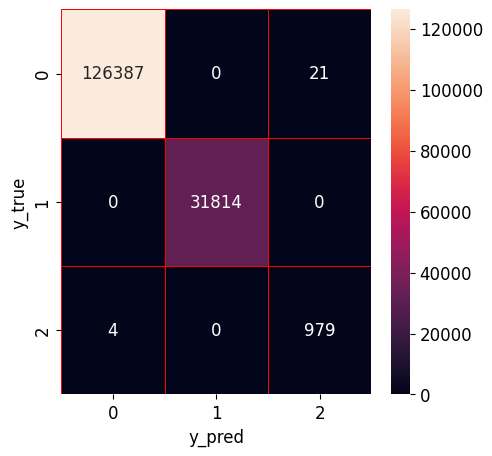

In [173]:
# %%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0, n_jobs=8)
rf_scores = cross_val_score(rf, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
rf.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

# Evaluation metrics
rf_score = rf.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Prediction time:  0.001021034894825442 ms
Accuracy of RF: 0.999411174103739
Precision of RF: 0.9994120113893177
Recall of RF: 0.999411174103739
F1-score of RF: 0.9994112302249174
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99786
           1       1.00      1.00      1.00     31787
           2       0.99      0.99      0.99       894

    accuracy                           1.00    132467
   macro avg       1.00      1.00      1.00    132467
weighted avg       1.00      1.00      1.00    132467



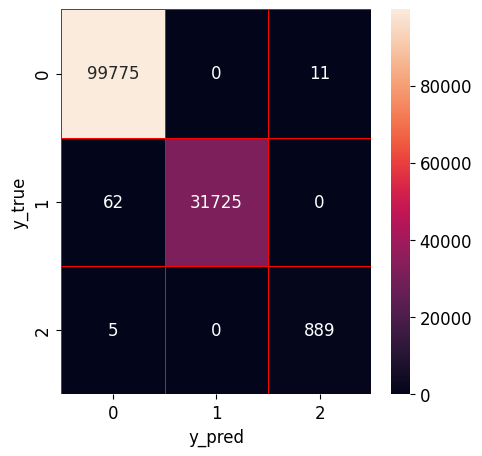

In [175]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test_fs)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
rf_score = rf.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [176]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf_untuned.pkl")

['./wedfri_2_models/postfs/rf_untuned.pkl']

100%|██████████| 20/20 [47:38<00:00, 142.94s/trial, best loss: -0.9997365373729172]
Random Forest: Hyperopt estimated optimum {'criterion': 'gini', 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 40}
Accuracy of RF: 0.999641971043623
Precision of RF: 0.9996522365470101
Recall of RF: 0.999641971043623
F1-score of RF: 0.9996449235655663
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.96      0.99      0.98       983

    accuracy                           1.00    159205
   macro avg       0.99      1.00      0.99    159205
weighted avg       1.00      1.00      1.00    159205



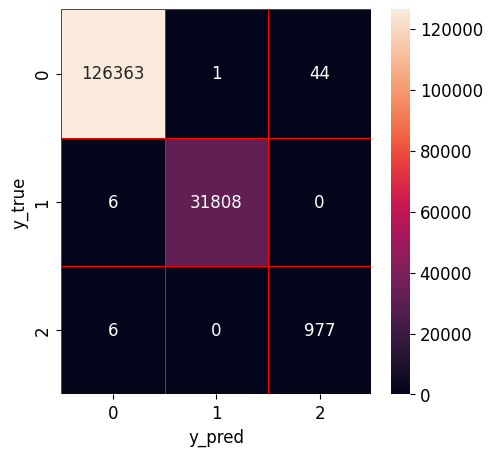

In [177]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = RandomForestClassifier(random_state=0, n_jobs=8, **params)
    score = cross_val_score(clf, X_train_balanced, y_train_balanced, scoring='accuracy', cv=StratifiedKFold(n_splits=3), n_jobs=8).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 40, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Random Forest: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
rf = RandomForestClassifier(random_state=0, **best)
rf.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = rf.predict(X_val)
y_true = y_val

# Evaluation metrics
rf_score = rf.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [178]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf.pkl")

['./wedfri_2_models/postfs/rf.pkl']

In [179]:
import gc
gc.collect()

29377

### ET

Training time:  17.42234468460083
Prediction time:  0.0011544832463412872 ms
Cross-Validation scores:  [0.99276347 0.99986748 0.99979175]
Mean of Cross-Validation scores:  0.997474233225193
Accuracy of ET: 0.999799001287648
Precision of ET: 0.9998027082970166
Recall of ET: 0.999799001287648
F1-score of ET: 0.9998001047073655
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.97      0.99      0.98       983

    accuracy                           1.00    159205
   macro avg       0.99      1.00      0.99    159205
weighted avg       1.00      1.00      1.00    159205



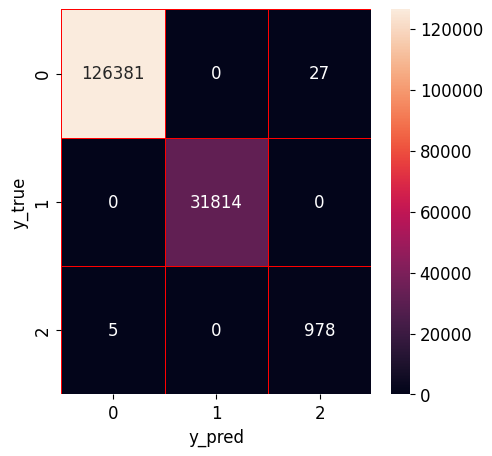

In [180]:
# %%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=8)
et_scores = cross_val_score(et, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
et.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(X_val) * 1000, 'ms')


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

# Evaluation metrics
et_score = et.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [181]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et_untuned.pkl")

['./wedfri_2_models/postfs/et_untuned.pkl']

100%|██████████| 20/20 [12:27<00:00, 37.36s/trial, best loss: -0.9998012197564413]
Extra Trees: Hyperopt estimated optimum {'criterion': 'gini', 'max_depth': 30, 'max_features': 8, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 97}
Accuracy of ET: 0.999786438868126
Precision of ET: 0.9997929722111493
Recall of ET: 0.999786438868126
F1-score of ET: 0.9997881355499972
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.97      1.00      0.98       983

    accuracy                           1.00    159205
   macro avg       0.99      1.00      0.99    159205
weighted avg       1.00      1.00      1.00    159205



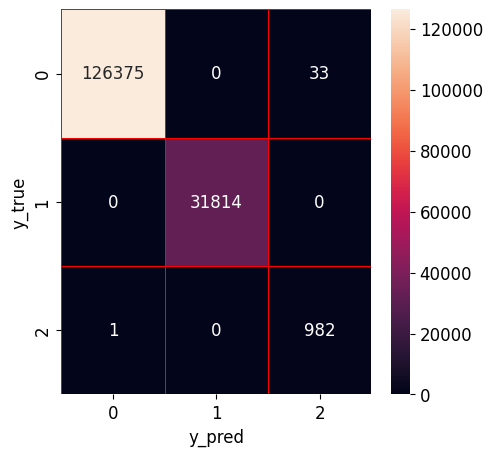

In [182]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = ExtraTreesClassifier(random_state=0, n_jobs=8, **params)
    score = cross_val_score(clf, X_train_balanced, y_train_balanced, scoring='accuracy', n_jobs=8, cv=StratifiedKFold(n_splits=3)).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'max_features': hp.quniform('max_features', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Extra Trees: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
et = ExtraTreesClassifier(random_state=0, **best)
et.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = et.predict(X_val)
y_true = y_val

# Evaluation metrics
et_score = et.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [183]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et.pkl")

['./wedfri_2_models/postfs/et.pkl']

In [184]:
import gc
gc.collect()

11330

### XGBoost

Training time:  5.398298025131226
Prediction time per sample:  0.0006646098535281998
Cross-Validation scores:  [0.99260255 0.99988168 0.99981542]
Mean of Cross-Validation scores:  0.9974332151940671
Accuracy of XGBoost: 0.999855532175497
Precision of XGBoost: 0.9998576652522864
Recall of XGBoost: 0.999855532175497
F1-score of XGBoost: 0.9998561465698709
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.98      1.00      0.99       983

    accuracy                           1.00    159205
   macro avg       0.99      1.00      1.00    159205
weighted avg       1.00      1.00      1.00    159205



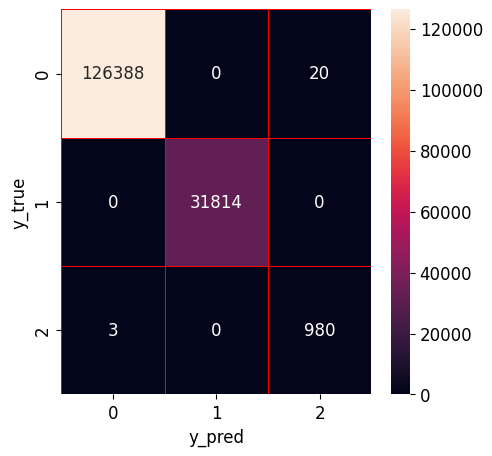

In [185]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=8)
xg_scores = cross_val_score(xg, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
xg.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

# Evaluation metrics
xg_score = xg.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Prediction time per sample:  0.0004350273549446364
Accuracy of XGBoost: 0.9976220641263035
Precision of XGBoost: 0.9976266528341365
Recall of XGBoost: 0.9976220641263035
F1-score of XGBoost: 0.9974831514888736
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120990
           1       1.00      1.00      1.00     31786
           2       1.00      0.74      0.85      1139

    accuracy                           1.00    153915
   macro avg       1.00      0.91      0.95    153915
weighted avg       1.00      1.00      1.00    153915



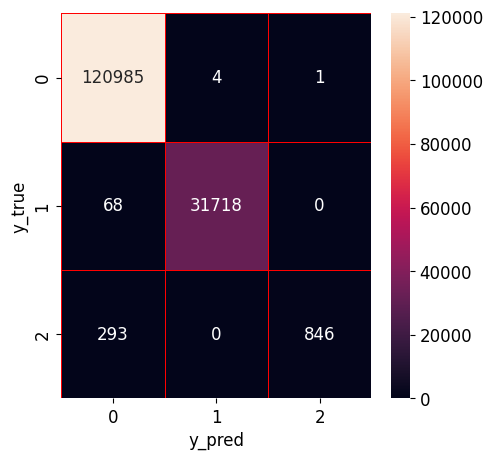

In [72]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)


y_true = y_test

# Evaluation metrics
xg_score = xg.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [186]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg_untuned.pkl")

['./wedfri_2_models/postfs/xg_untuned.pkl']

100%|██████████| 20/20 [01:05<00:00,  3.30s/trial, best loss: -0.999830407336453]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.7286019691074549, 'max_depth': 8, 'n_estimators': 25}
Accuracy of XGBoost: 0.999830407336453
Precision of XGBoost: 0.9998323854099921
Recall of XGBoost: 0.999830407336453
F1-score of XGBoost: 0.9998310443772189
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.98      0.99      0.99       983

    accuracy                           1.00    159205
   macro avg       0.99      1.00      1.00    159205
weighted avg       1.00      1.00      1.00    159205



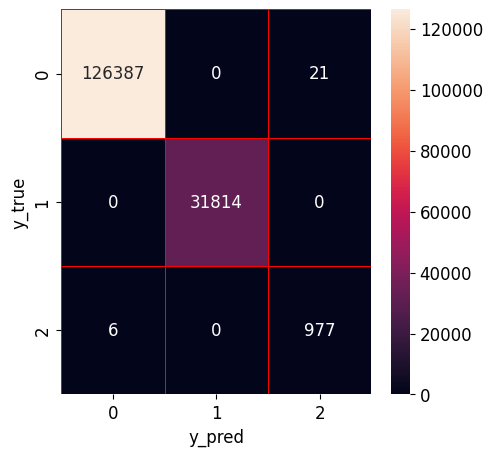

In [187]:
# Hyperparameter Optimization using BO-TPE

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate']))
    }
    clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0, n_jobs=8, **params)
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_val)
    score = accuracy_score(y_val, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))

print("XGBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0, **best)
xg.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = xg.predict(X_val)
y_true = y_val

# Evaluation metrics
xg_score = xg.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [188]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg.pkl")

['./wedfri_2_models/postfs/xg.pkl']

### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9523
[LightGBM] [Info] Number of data points in the train set: 422577, number of used features: 42
[LightGBM] [Info] Start training from score -0.513714
[LightGBM] [Info] Start training from score -1.893349
[LightGBM] [Info] Start training from score -1.381650
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

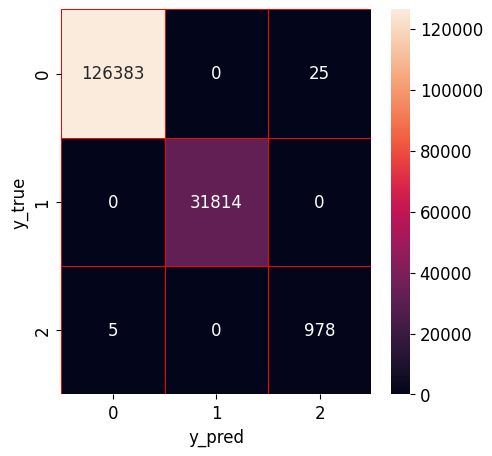

In [189]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=8)
lgbm_scores = cross_val_score(lgbm, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
lgbm.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)



y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [190]:
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm_untuned.pkl")

['./wedfri_2_models/postfs/lgbm_untuned.pkl']

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9518                     
[LightGBM] [Info] Number of data points in the train set: 633866, number of used features: 42
[LightGBM] [Info] Start training from score -0.513713 
[LightGBM] [Info] Start training from score -1.893350 
[LightGBM] [Info] Start training from score -1.381651 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines 
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9518                                        

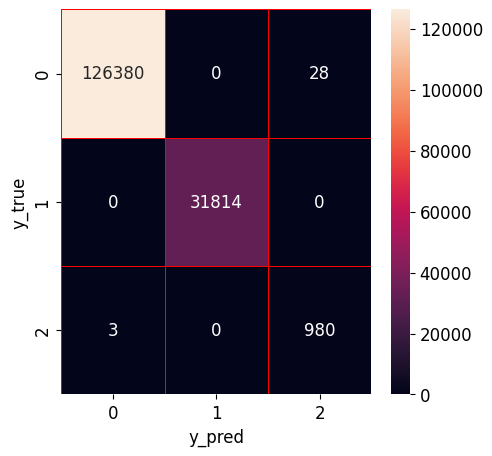

In [191]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_val)
    score = accuracy_score(y_val, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
    'num_leaves': hp.quniform('num_leaves', 10, 200, 5),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 5)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
lgbm = lgb.LGBMClassifier(random_state=0, **best)
lgbm.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = lgbm.predict(X_val)
y_true = y_val

# Evaluation metrics
lgbm_score = lgbm.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [192]:
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm.pkl")

['./wedfri_2_models/postfs/lgbm.pkl']

### CatBoost

Training time:  66.79783368110657
Prediction time per sample:  0.0005647991699533117
Cross-Validation scores:  [0.99243217 0.99985328 0.99978702]
Mean of Cross-Validation scores:  0.9973574894844196
Accuracy of CatBoost: 0.999755032819321
Precision of CatBoost: 0.9997611454474287
Recall of CatBoost: 0.999755032819321
F1-score of CatBoost: 0.9997567992310881
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.97      0.99      0.98       983

    accuracy                           1.00    159205
   macro avg       0.99      1.00      0.99    159205
weighted avg       1.00      1.00      1.00    159205



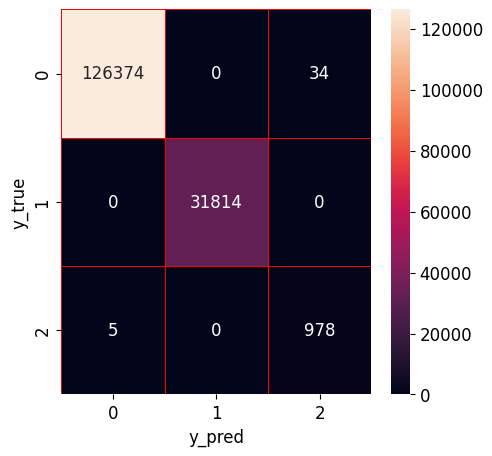

In [193]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, thread_count=8, verbose=False)
cat_scores = cross_val_score(cat, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)


# calculate the training time
start = time.time()
cat.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)


# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

# Evaluation metrics
cat_score = cat.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [194]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat_untuned.pkl")

['./wedfri_2_models/postfs/cat_untuned.pkl']

100%|██████████| 20/20 [33:46<00:00, 101.32s/trial, best loss: -0.999792720077887]
CatBoost: Hyperopt estimated optimum {'depth': 10, 'iterations': 800, 'learning_rate': 0.05017718804916099}
Accuracy of CatBoost: 0.999792720077887
Precision of CatBoost: 0.9997982970445899
Recall of CatBoost: 0.999792720077887
F1-score of CatBoost: 0.9997942147339975
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126408
           1       1.00      1.00      1.00     31814
           2       0.97      1.00      0.98       983

    accuracy                           1.00    159205
   macro avg       0.99      1.00      0.99    159205
weighted avg       1.00      1.00      1.00    159205



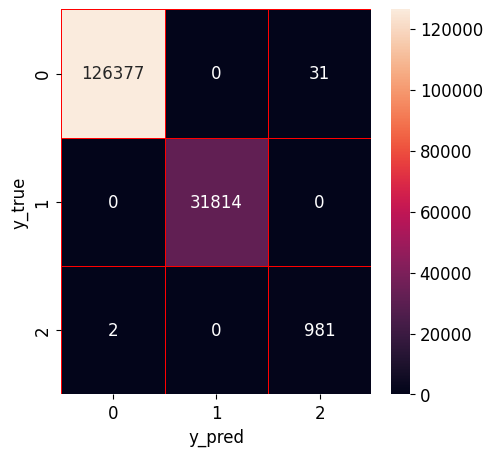

In [195]:
# Hyperparameter Optimization using BO-TPE

import catboost as cb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'depth': int(params['depth']),
        'learning_rate': params['learning_rate'],
        'iterations': int(params['iterations'])
    }
    clf = cb.CatBoostClassifier(random_state=0, verbose=False, thread_count=8, **params)
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_val)
    score = accuracy_score(y_val, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'depth': hp.quniform('depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'iterations': hp.quniform('iterations', 100, 1000, 100)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['depth'] = int(best['depth'])
best['learning_rate'] = best['learning_rate']
best['iterations'] = int(best['iterations'])

print("CatBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
cat = cb.CatBoostClassifier(random_state=0, verbose=False, **best)
cat.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = cat.predict(X_val)
y_true = y_val

# Evaluation metrics
cat_score = cat.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [196]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat.pkl")

['./wedfri_2_models/postfs/cat.pkl']

In [197]:
# record the results
dt_train=dt.predict(X_train_balanced)
dt_test=dt.predict(X_val)
dt_prob_train=dt.predict_proba(X_train_balanced)
dt_prob_test=dt.predict_proba(X_val)

rf_train=rf.predict(X_train_balanced)
rf_test=rf.predict(X_val)
rf_prob_train=rf.predict_proba(X_train_balanced)
rf_prob_test=rf.predict_proba(X_val)

et_train=et.predict(X_train_balanced)
et_test=et.predict(X_val)
et_prob_train=et.predict_proba(X_train_balanced)
et_prob_test=et.predict_proba(X_val)

xg_train=xg.predict(X_train_balanced)
xg_test=xg.predict(X_val)
xg_prob_train=xg.predict_proba(X_train_balanced)
xg_prob_test=xg.predict_proba(X_val)

lgbm_train=lgbm.predict(X_train_balanced)
lgbm_test=lgbm.predict(X_val)
lgbm_prob_train=lgbm.predict_proba(X_train_balanced)
lgbm_prob_test=lgbm.predict_proba(X_val)

cat_train=cat.predict(X_train_balanced)
cat_test=cat.predict(X_val)
cat_prob_train=cat.predict_proba(X_train_balanced)
cat_prob_test=cat.predict_proba(X_val)


# Model Export

In [59]:
import joblib

joblib.dump(dt, "Models/dt.pkl")
joblib.dump(rf, "Models/rf.pkl")
joblib.dump(et, "Models/et.pkl")
joblib.dump(xg, "Models/xg.pkl")
joblib.dump(lgbm, "Models/lgbm.pkl")
joblib.dump(cat, "Models/cat.pkl")

['Models/cat.pkl']

In [60]:
lgbm_imported = joblib.load("Models/lgbm.pkl")

In [ ]:
import_test = lgbm_imported.predict(X_val).reshape(-1,1)
import_test

array([[0],
       [1],
       [3],
       ...,
       [0],
       [3],
       [3]])

In [122]:
top_3_models

['rf', 'et', 'lgbm']

In [71]:
fs

['Bwd Packet Length Min',
 'Bwd Packet Length Std',
 'Init_Win_bytes_forward',
 'Average Packet Size',
 'Init_Win_bytes_backward',
 'PSH Flag Count',
 'Bwd Packets/s',
 'Fwd PSH Flags',
 'Avg Bwd Segment Size',
 'Bwd Header Length',
 'Fwd Header Length',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'min_seg_size_forward',
 'Bwd Packet Length Mean',
 'Fwd Header Length.1',
 'Flow Bytes/s',
 'Bwd Packet Length Max',
 'Max Packet Length',
 'Flow IAT Min',
 'Total Length of Fwd Packets',
 'Fwd Packet Length Mean',
 'Total Length of Bwd Packets',
 'Fwd Packet Length Max',
 'Fwd IAT Min',
 'Avg Fwd Segment Size',
 'Total Fwd Packets',
 'Subflow Bwd Bytes',
 'Subflow Fwd Bytes',
 'Flow IAT Max',
 'Total Backward Packets',
 'Fwd IAT Mean',
 'Bwd IAT Min',
 'act_data_pkt_fwd',
 'Fwd Packets/s',
 'URG Flag Count',
 'Flow IAT Std',
 'Min Packet Length']

## Model selection

In [200]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]



In [201]:
top_3_models

['et', 'rf', 'lgbm']

In [202]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
lgbm_train=lgbm_train.reshape(-1, 1)
cat_train=cat_train.reshape(-1, 1)


dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)
lgbm_test=lgbm_test.reshape(-1, 1)
cat_test=cat_test.reshape(-1, 1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9
[LightGBM] [Info] Number of data points in the train set: 633866, number of used features: 3
[LightGBM] [Info] Start training from score -0.513713
[LightGBM] [Info] Start training from score -1.893350
[LightGBM] [Info] Start training from score -1.381651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

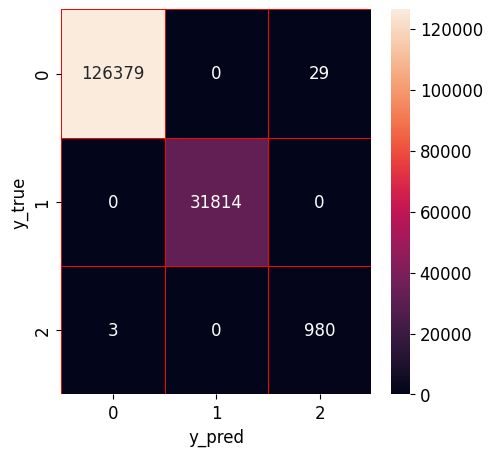

In [203]:
# Ensemble method 1: traditional stacking

# Get the predictions of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

# Stack the predictions of the top-3 models
x_train_balanced = np.concatenate(top_3_train_predictions, axis=1)
x_val = np.concatenate(top_3_test_predictions, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)
y_predict=stk.predict(x_val)
y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [204]:
joblib.dump(stk, f"{POST_FS_MODEL_OUTPUT}/stk1.pkl")

['./wedfri_2_models/postfs/stk1.pkl']

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2186
[LightGBM] [Info] Number of data points in the train set: 633866, number of used features: 9
[LightGBM] [Info] Start training from score -0.513713
[LightGBM] [Info] Start training from score -1.893350
[LightGBM] [Info] Start training from score -1.381651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

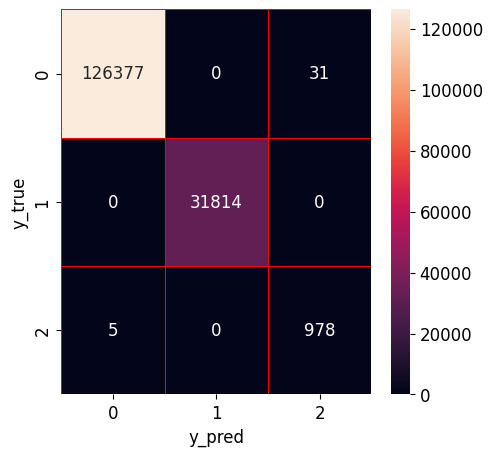

In [205]:
# Ensemble method 2: confidence-based stacking

# Get the prediction probabilities of the top-3 models
top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Stack the predictions and prediction probabilities of the top-3 models
x_train_balanced = np.concatenate(top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_test_proba, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)
y_predict=stk.predict(x_val)
y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [206]:
joblib.dump(stk, f"{POST_FS_MODEL_OUTPUT}/stk2.pkl")

['./wedfri_2_models/postfs/stk2.pkl']

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2195
[LightGBM] [Info] Number of data points in the train set: 633866, number of used features: 12
[LightGBM] [Info] Start training from score -0.513713
[LightGBM] [Info] Start training from score -1.893350
[LightGBM] [Info] Start training from score -1.381651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

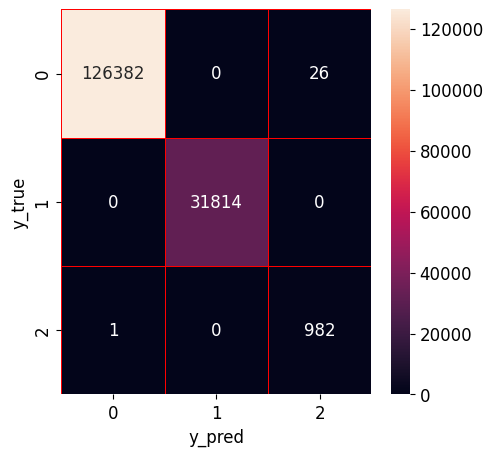

In [208]:
# Ensemble method 3: hybrid stacking
# Get the predictions and prediction probabilities of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_train_balanced = np.concatenate(top_3_train_predictions + top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_test_predictions + top_3_test_proba, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)
y_predict=stk.predict(x_val)
y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

# PS: the hyperparameter optimization process is the same as the previous steps

In [209]:
joblib.dump(stk, f"{POST_FS_MODEL_OUTPUT}/stk3.pkl")

['./wedfri_2_models/postfs/stk3.pkl']

# Final Test

In [210]:
# df_test = pd.read_csv('/mnt/extra/datasets/processed/friday_annotated_test_rerun.csv')
# df_test

In [211]:
# X_test = df_test[fs]
# X_test

In [212]:
# y_test = df_test['Label']
# y_test

In [213]:
# y_test = labelencoder.transform(y_test)

In [216]:
# record the results
dt_test_real=dt.predict(X_test_fs)
dt_prob_test_real=dt.predict_proba(X_test_fs)

rf_test_real=rf.predict(X_test_fs)
rf_prob_test_real=rf.predict_proba(X_test_fs)

et_test_real=et.predict(X_test_fs)
et_prob_test_real=et.predict_proba(X_test_fs)

xg_test_real=xg.predict(X_test_fs)
xg_prob_test_real=xg.predict_proba(X_test_fs)

lgbm_test_real=lgbm.predict(X_test_fs)
lgbm_prob_test_real=lgbm.predict_proba(X_test_fs)

cat_test_real=cat.predict(X_test_fs)
cat_prob_test_real=cat.predict_proba(X_test_fs)

In [217]:
dt_test_real=dt_test_real.reshape(-1, 1)
rf_test_real=rf_test_real.reshape(-1, 1)
et_test_real=et_test_real.reshape(-1, 1)
xg_test_real=xg_test_real.reshape(-1, 1)
lgbm_test_real=lgbm_test_real.reshape(-1, 1)
cat_test_real=cat_test_real.reshape(-1, 1)

Accuracy of Stacking: 0.9993432326541705
Precision of Stacking: 0.9993445699229824
Recall of Stacking: 0.9993432326541705
F1-score of Stacking: 0.9993434949657019
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99786
           1       1.00      1.00      1.00     31787
           2       0.98      0.99      0.99       894

    accuracy                           1.00    132467
   macro avg       0.99      1.00      1.00    132467
weighted avg       1.00      1.00      1.00    132467



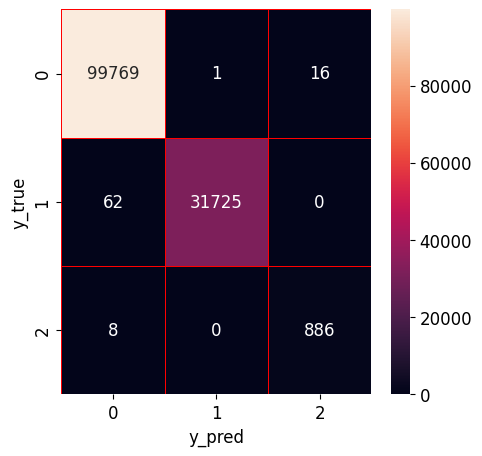

In [218]:
y_predict=lgbm.predict(X_test_fs)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [219]:
# Ensemble method 3: hybrid stacking
# Get the predictions and prediction probabilities of the top-3 models
top_3_test_real_predictions = [globals()[model.lower() + '_test_real'] for model in top_3_models]

top_3_test_real_proba = [globals()[model.lower() + '_prob_test_real'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_test_real = np.concatenate(top_3_test_real_predictions + top_3_test_real_proba, axis=1)

Accuracy of Stacking: 0.9993205855043142
Precision of Stacking: 0.9993215518562627
Recall of Stacking: 0.9993205855043142
F1-score of Stacking: 0.9993207366078608
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99786
           1       1.00      1.00      1.00     31787
           2       0.98      0.99      0.98       894

    accuracy                           1.00    132467
   macro avg       0.99      1.00      0.99    132467
weighted avg       1.00      1.00      1.00    132467



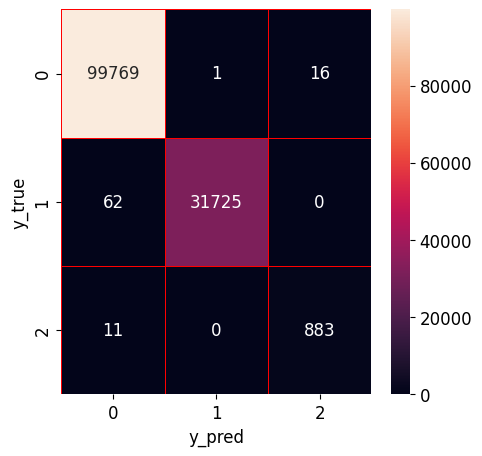

In [220]:
y_predict=stk.predict(x_test_real)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()